# RPM Data Extraction and Visualization

This notebook is designed to extract and analyze the Revolutions Per Minute (RPM) data of motors from PX4 ULog files. The RPM data represents the speed of the motors, typically measured in rotations per minute, and is crucial for understanding motor performance during flight.

### Goals:
1. Extract the **timestamp** and **RPM values** for all available ESCs (Electronic Speed Controllers) from the `esc_status` dataset.
2. Save the extracted data into a CSV file for further analysis or archival purposes.
3. Visualize the RPM data over time for each ESC to analyze motor behavior during the flight.

### Outputs:
1. A CSV file containing:
   - `Timestamp`: Time in milliseconds.
   - `ESC_X_RPM`: RPM values for each ESC (e.g., `ESC_0_RPM`, `ESC_1_RPM`, etc.).
2. A line graph plotting RPM values over time for each ESC, enabling comparison and analysis.

### How it Works:
- The `esc_status` dataset in the ULog file contains RPM data for each ESC. This data is extracted and aligned with timestamps.
- The extracted data is saved to a structured CSV file for easy accessibility.
- Visualizations provide insights into motor performance, highlighting potential irregularities or trends.

### Why It’s Important:
Analyzing motor RPM helps ensure:
- **System reliability**: Identifying potential motor failures or performance issues.
- **Flight stability**: Understanding motor response to control commands.
- **Optimization**: Ensuring motors operate within safe and efficient RPM ranges.


In [12]:
import math
import matplotlib.pyplot as plt
from pyulog import ULog

In [13]:
def extract_rpm_data(ulog):
    """
    Extract RPM data from the 'esc_status' dataset in the ULog file.
    
    :param ulog: ULog object
    :return: List of tuples [(timestamp, esc_0_rpm, esc_1_rpm, ...)]
    """
    try:
        esc_data = ulog.get_dataset("esc_status")
        timestamps = esc_data.data['timestamp']
        esc_rpm_fields = [f'esc[{i}].esc_rpm' for i in range(8)]  # Up to 8 ESCs

        # Ensure only valid fields are processed
        available_esc_fields = [field for field in esc_rpm_fields if field in esc_data.data]

        # Extract data
        rpm_data = []
        for i, timestamp in enumerate(timestamps):
            row = [timestamp]
            for field in available_esc_fields:
                row.append(esc_data.data[field][i])
            rpm_data.append(row)

        return rpm_data, available_esc_fields
    except KeyError:
        print("esc_status dataset not available in the log.")
        return [], []


In [14]:

def save_rpm_to_csv(rpm_data, esc_fields, filename):
    """
    Save the RPM data to a CSV file.
    
    :param rpm_data: List of tuples [(timestamp, esc_0_rpm, esc_1_rpm, ...)]
    :param esc_fields: List of ESC field names (e.g., ['esc[0].esc_rpm', ...])
    :param filename: Output CSV file path
    """
    import csv
    try:
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            # Write header
            header = ['Timestamp'] + esc_fields
            writer.writerow(header)
            # Write data rows
            writer.writerows(rpm_data)
        print(f"RPM data saved to {filename}")
    except Exception as e:
        print(f"Error saving RPM data: {e}")


In [15]:
def plot_rpm_data(rpm_data, esc_fields):
    """
    Plot RPM data over time.
    
    :param rpm_data: List of tuples [(timestamp, esc_0_rpm, esc_1_rpm, ...)]
    :param esc_fields: List of ESC field names (e.g., ['esc[0].esc_rpm', ...])
    """
    import matplotlib.pyplot as plt
    
    timestamps = [row[0] for row in rpm_data]
    plt.figure(figsize=(12, 6))
    
    for i, field in enumerate(esc_fields):
        esc_rpm = [row[i + 1] for row in rpm_data]  # Offset by 1 for timestamps
        plt.plot(timestamps, esc_rpm, label=f'{field} RPM')

    plt.xlabel('Timestamp [ms]')
    plt.ylabel('RPM')
    plt.title('ESC RPM Over Time')
    plt.legend()
    plt.grid()
    plt.show()


In [16]:
def main():
    path_to_csv = 'csv_files/trajectory_rpm.csv'
    ulog_file = '/home/hawk/GitDir/Logging/2024-12-09/12_40_59.ulg'
    ulog = ULog(ulog_file)

    # Extract RPM data
    rpm_data, esc_fields = extract_rpm_data(ulog)

    if rpm_data:
        # Save to CSV
        save_rpm_to_csv(rpm_data, [f.replace("esc[", "ESC_").replace("].esc_rpm", "_RPM") for f in esc_fields], path_to_csv)
        
        # Plot data
        plot_rpm_data(rpm_data, [f.replace("esc[", "ESC_").replace("].esc_rpm", "_RPM") for f in esc_fields])

RPM data saved to csv_files/trajectory_rpm.csv


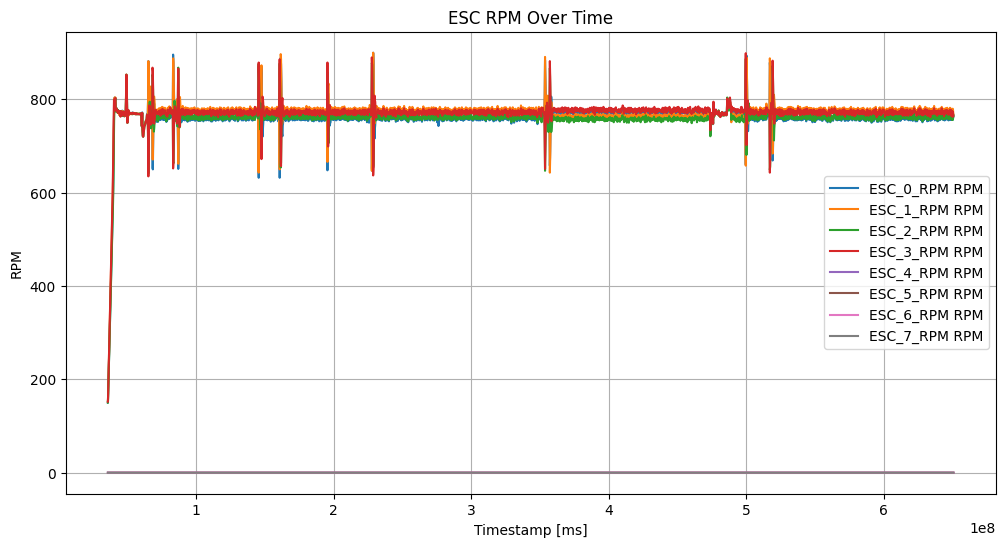

In [17]:
if __name__ == "__main__":
    main()
